#Modelo de clasificación: Procesado completo + Red Neuronal

Exploración inicial del entrenamiento de una red neuronal mediante tensorflow utilizando un procesado inicial completo con descomposición PCA inicial que ha mostrado que incrementa la precisión en la predicción. Los resultados previos de la regresión logistica ayudan a identificar paramétros iniciales como la elección del optimizador y su learning rate encontrando que el de mejor resultados es el AdamW

##Instrucciones Generales

Para poder ejecutar el procesamiento propuesto, es necesario cargar tanto los archivos de la competencia de kaggle como el archivo de categorización manual de programas por área de conocimiento.

Para cargar los archivos de la competencia se puede:

1. Descargar directamente desde la página de kaggle: https://www.kaggle.com/competitions/udea-ai-4-eng-20251-pruebas-saber-pro-colombia/data y luego cargar manualmente al entorno

2. O ejecutar las celdas de carga directa utilizando una api-key propia de kaggle (archivo kaggle.json) que se debe cargar al entorno

Finalmente se debe cargar el archivo Categorias.csv que se ha enlazado en el repositorio github de esta solución para poder aplicar el procesamiento

##Importaciones básicas

In [ ]:
import numpy as np
import pandas as pd

try:
    %tensorflow_version 2.x
    print ("Using TF2 in Google Colab")
except:
    pass

import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Using TF2 in Google Colab


##Preprocesado de los datos

###Carga de los datos

In [ ]:
!mkdir /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.config/kaggle/kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.13GB/s]
Archive:  udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


###Creacion dataframe y su transformación

####Definición de las funciones de transformación

In [ ]:
## Transformar columnas de si o no
def to_binary(df, columns):

  df_copy = df.copy()

  for col in columns:
    not_null_column =  df_copy.loc[~df_copy[col].isna()]
    not_null_column = ((not_null_column =="Si") | (not_null_column == "S")).astype(int)
    df_copy.loc[~df_copy[col].isna(), col] = not_null_column[col]

  return df_copy

## Transformación rangos categoricos con orden implicito
def define_education_levels():
  education = []
  education.append("Ninguno")
  education.append("Primaria incompleta")
  education.append("Primaria completa")
  education.append("Secundaria (Bachillerato) incompleta")
  education.append("Secundaria (Bachillerato) completa")
  education.append("Técnica o tecnológica incompleta")
  education.append("No Aplica")
  education.append("No sabe")
  education.append("Técnica o tecnológica completa")
  education.append("Educación profesional incompleta")
  education.append("Educación profesional completa")
  education.append("Postgrado")
  return education

def to_ordered_categories(df, column, values):

  df_copy = df.copy()
  keys = [int(i) for i in range(len(values))]
  replacement = dict(zip(values, keys))
  df_copy[column] = df_copy[column].replace(replacement)
  return df_copy

## Transformación one hot
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)

def replace_columns_with_onehot(d, col):
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%d"%(col, i) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r

def create_dictionary_programs(programs_df):
  programs = {}
  for program, cat in zip(programs_df['PROGRAMA   '], programs_df['CATEGORIA']):
    if cat not in programs.keys():
      programs[cat] = [program]
    else:
      programs[cat].append(program)

  return programs

def add_knowledge_area_cols(df, programs):
  df_copy = df.copy()

  for area in programs.keys():
    column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =[area])
    df_copy = df_copy.join(column)

  other_column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =['OTRO'])
  df_copy = df_copy.join(other_column)

  return df_copy

def categorize_programs(df, programs):
  df_copy = df.copy()

  def assign_area(program):
    for area in programs.keys():
      if program in programs[area]:
        return area

    return 'OTRO'

  df_copy['AREA_TMP'] = df_copy['ESTU_PRGM_ACADEMICO'].apply(assign_area)

  for area in programs.keys():
      df_copy[area] = (df_copy['AREA_TMP'] == area).astype(int)

  df_copy['OTRO'] = (df_copy['AREA_TMP'] == 'OTRO').astype(int)
  df_copy = df_copy.drop(columns=['AREA_TMP'])

  return df_copy

def fill_nulls(df, columns):

  df_copy = df.copy()
  for col in columns:
    p = []
    n = df_copy[col].dropna().shape[0]
    for val in df_copy[col].dropna().unique():
      p.append(np.sum(df_copy[col]==val)/n)

    total_nulls = df_copy[col].shape[0]-n
    values = np.random.choice(df_copy[col].dropna().unique(),size=total_nulls, p=p)

    df_copy.loc[df_copy[col].isna(),col] = values.astype(int)
    df_copy[col] = df_copy[col].astype(int)

  return df_copy

In [ ]:
def process_data(df, programs_df):

  df_copy = df.copy()
  # drop ID column - repeated internet
  del(df_copy['ID'])
  df_copy = df_copy.drop(columns=['FAMI_TIENEINTERNET.1'])
  # Cambio a binarias
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL',
           'FAMI_TIENECOMPUTADOR','ESTU_PAGOMATRICULAPROPIO', 'ESTU_PRIVADO_LIBERTAD']

  df_copy = to_binary(df_copy, columns)
  ## Categorias ordenadas
  # Estrato
  values = ["Sin Estrato", "Estrato 1", "Estrato 2", "Estrato 3", "Estrato 4", "Estrato 5", "Estrato 6"]
  df_copy = to_ordered_categories(df_copy, "FAMI_ESTRATOVIVIENDA", values)
  # Educacion padres
  education = define_education_levels()
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONPADRE", education)
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONMADRE", education)
  # horas trabajo
  values = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']
  df_copy = to_ordered_categories(df_copy,"ESTU_HORASSEMANATRABAJA", values)
  # valor matricula
  values = ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
          'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones',
          'Entre 5.5 millones y menos de 7 millones','Más de 7 millones']

  df_copy = to_ordered_categories(df_copy,"ESTU_VALORMATRICULAUNIVERSIDAD", values)
  # periodo
  values = [20183, 20184, 20194, 20195, 20196, 20202, 20203, 20212, 20213]
  df_copy = to_ordered_categories(df_copy,"PERIODO", values)
  # Variable respuesta
  if 'RENDIMIENTO_GLOBAL' in df_copy.columns:
    grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
    df_copy = to_ordered_categories(df_copy,"RENDIMIENTO_GLOBAL", grades)

  # One hot  departamentos
  df_copy = replace_columns_with_onehot(df_copy, 'ESTU_PRGM_DEPARTAMENTO')

  # Areas de conocimiento - clasificación programas
  # creacion diccionario
  programs = create_dictionary_programs(programs_df)
  # creacion columnas
  df_copy = add_knowledge_area_cols(df_copy, programs)
  # categorizacion
  df_copy = categorize_programs(df_copy, programs)

  # Relleno nulos
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR',
           'ESTU_PAGOMATRICULAPROPIO','ESTU_PRIVADO_LIBERTAD', 'FAMI_ESTRATOVIVIENDA','FAMI_EDUCACIONPADRE',
           'FAMI_EDUCACIONMADRE', 'ESTU_HORASSEMANATRABAJA','ESTU_VALORMATRICULAUNIVERSIDAD']

  df_copy = fill_nulls(df_copy, columns)

  return df_copy

####Dataframe resultante

In [ ]:
try:
  df = pd.read_csv("train.csv")
except:
  print("No se ha cargado el archivo train.csv al entorno")

In [ ]:
try:
    programs_df = pd.read_csv('Categorias.csv', sep=';',encoding='latin-1')
    programs_df = programs_df.sample(frac=0.70, random_state=42)
    df = process_data(df, programs_df)
    print(df.shape)
except:
    print("No se ha cargado el archivo Categorias.csv al entorno")

/tmp/ipython-input-4-3166745170.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


(692500, 59)


###Separación de los datos

In [ ]:
X = df.drop(columns=['RENDIMIENTO_GLOBAL', 'ESTU_PRGM_ACADEMICO'])
y = df['RENDIMIENTO_GLOBAL']
print(X.shape)
print(y.shape)

(692500, 57)
(692500,)


##Creación y evaluacion del modelo

###Split de los datos de la muestra con train: 70% - test: 30%

In [ ]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.3)

###Modelo y calibración

####Descomposición PCA

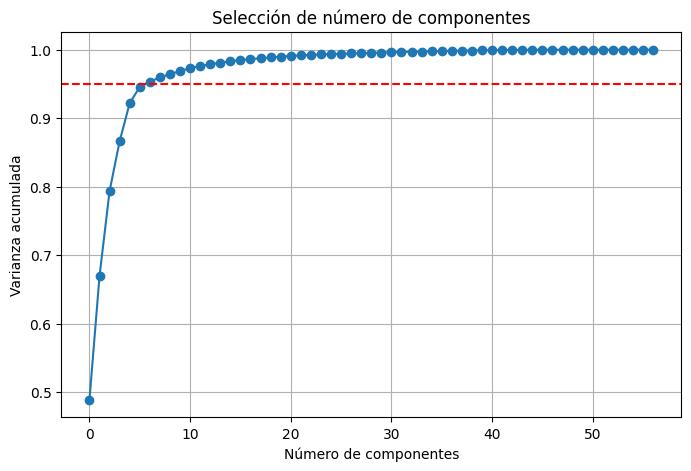

Se necesitan 7 componentes para conservar el 95% de la varianza


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(Xtr)

# Varianza acumulada
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(cumulative_var, marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.grid(True)
plt.axhline(0.95, color='r', linestyle='--')  # Umbral deseado
plt.title("Selección de número de componentes")
plt.show()

# Elegir el número que conserve al menos el 95%
n_components = np.argmax(cumulative_var >= 0.95) + 1
print(f"Se necesitan {n_components} componentes para conservar el 95% de la varianza")

In [ ]:
from sklearn.model_selection import train_test_split

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def evaluate(model, X, y):
  _, acc = model.evaluate(X, y, verbose=0)
  return acc

def bootstrap_score(X, y, test_size, iterations=3):
  trscores, tsscores = [], []
  for _ in range(iterations):

    model = build_model()
    Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=test_size)
    ytr = pd.get_dummies(ytr).astype(int)
    yts = pd.get_dummies(yts).astype(int)
    model.fit(Xtr, ytr, epochs=20, batch_size=512,verbose=0)
    trscores.append(evaluate(model, Xtr, ytr))
    tsscores.append(evaluate(model, Xts, yts))

  return (np.mean(trscores), np.std(trscores)), (np.mean(tsscores), np.std(tsscores))

In [ ]:
max_acc = 0
n_components = 10

for i in range(10, X.shape[1], 6):
  pca = PCA(n_components=i)
  pca.fit(Xtr)
  X_pca = pca.transform(X)

  tr_sc, ts_sc = bootstrap_score(X_pca, y, 0.3)

  if ts_sc[0] - ts_sc[1] > max_acc:
    max_acc = ts_sc[0]
    n_components = i

  print(f"Decomposition with {i} components. Train accuracy {tr_sc[0]:6f} ­± {tr_sc[1]:6f}, Test accuracy: {ts_sc[0]:6f} ± {ts_sc[1]:6f}")

max_acc = 0

for i in range(n_components-3, min(n_components+4, X.shape[1])):
  pca = PCA(n_components=i)
  pca.fit(Xtr)
  X_pca = pca.transform(X)

  tr_sc, ts_sc = bootstrap_score(X_pca, y, 0.3)

  if ts_sc[0] - ts_sc[1] > max_acc:
    max_acc = ts_sc[0]
    n_components = i

  print(f"Decomposition with {i} components. Train accuracy {tr_sc[0]:6f} ­± {tr_sc[1]:6f}, Test accuracy: {ts_sc[0]:6f} ± {ts_sc[1]:6f}")

print(f"Best decomposition with {n_components}")

Decomposition with 10 components. Train accuracy 0.401778 ­± 0.000428, Test accuracy: 0.400579 ± 0.000582
Decomposition with 16 components. Train accuracy 0.408576 ­± 0.000428, Test accuracy: 0.405993 ± 0.001327
Decomposition with 22 components. Train accuracy 0.412943 ­± 0.000824, Test accuracy: 0.409117 ± 0.000733
Decomposition with 28 components. Train accuracy 0.416488 ­± 0.000706, Test accuracy: 0.414965 ± 0.000699
Decomposition with 34 components. Train accuracy 0.418845 ­± 0.000246, Test accuracy: 0.415676 ± 0.001157
Decomposition with 40 components. Train accuracy 0.422330 ­± 0.000560, Test accuracy: 0.418079 ± 0.000721
Decomposition with 46 components. Train accuracy 0.423051 ­± 0.000117, Test accuracy: 0.419591 ± 0.000893
Decomposition with 52 components. Train accuracy 0.422541 ­± 0.000355, Test accuracy: 0.417972 ± 0.000493
Decomposition with 43 components. Train accuracy 0.423052 ­± 0.000199, Test accuracy: 0.417914 ± 0.000733
Decomposition with 44 components. Train accura

In [ ]:
pca = PCA(n_components=n_components)
pca.fit(X)
X_pca = pca.transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X_pca,y, test_size=0.3)

####One-hot encoding variable salida

In [ ]:
print(ytr.shape)
ytr = pd.get_dummies(ytr).astype(int)
yts = pd.get_dummies(yts).astype(int)
print(ytr.shape)

(484750,)
(484750, 4)


#####Función de graficación de entrenamiento

In [ ]:
def plot_training_history(history):
    import matplotlib.pyplot as plt

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')
    plt.title('Precisión por época')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'g--', label='Validation Loss')
    plt.title('Pérdida por época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

####Sin capas intermedias

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Dense(4, activation='softmax'),
  ])

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(Xtr, ytr, epochs=20, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print()
print(f"Train accuracy {acc_tr}, Test accuracy: {acc}")

Epoch 1/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3321 - loss: 1.4155 - val_accuracy: 0.3785 - val_loss: 1.2874
Epoch 2/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3812 - loss: 1.2865 - val_accuracy: 0.3802 - val_loss: 1.2842
Epoch 3/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3835 - loss: 1.2828 - val_accuracy: 0.3800 - val_loss: 1.2837
Epoch 4/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3841 - loss: 1.2834 - val_accuracy: 0.3794 - val_loss: 1.2836
Epoch 5/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3831 - loss: 1.2833 - val_accuracy: 0.3794 - val_loss: 1.2835
Epoch 6/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3847 - loss: 1.2831 - val_accuracy: 0.3803 - val_loss: 1.2833
Epoch 7/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3827 - loss: 1.2836 - val_accuracy: 0.3807 - val_loss: 1.2833
Epoch 8/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3826 - loss: 1.2843 - val_accuracy: 0.

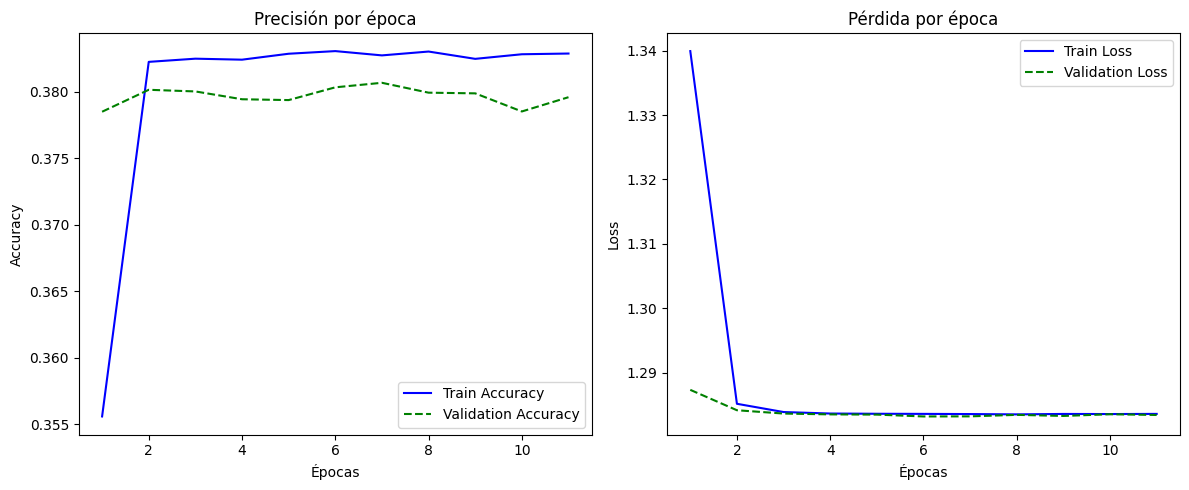

In [ ]:
plot_training_history(history)

####Una capa intermedias

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3610 - loss: 1.3219 - val_accuracy: 0.3811 - val_loss: 1.2827
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3848 - loss: 1.2798 - val_accuracy: 0.3896 - val_loss: 1.2689
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3959 - loss: 1.2646 - val_accuracy: 0.3999 - val_loss: 1.2549
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4061 - loss: 1.2515 - val_accuracy: 0.4035 - val_loss: 1.2494
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4071 - loss: 1.2483 - val_accuracy: 0.4077 - val_loss: 1.2460
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4093 - loss: 1.2453 - val_accuracy: 0.4075 - val_loss: 1.2438
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4122 - loss: 1.2417 - val_accuracy: 0.4071 - val_loss: 1.2433
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4123 - loss: 1.2399 - val_accuracy: 0.

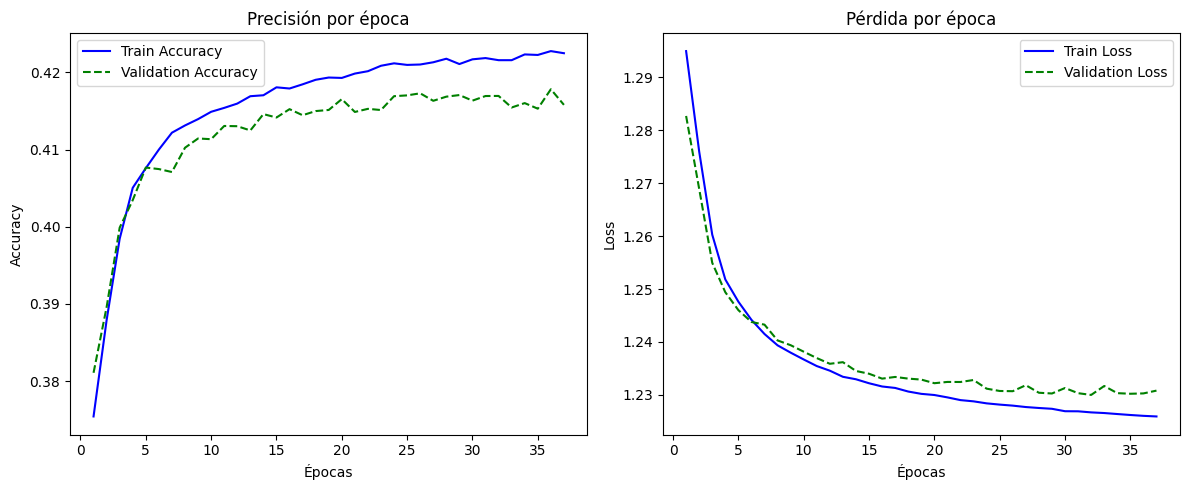

In [ ]:
plot_training_history(history)

####Dos capas intermedias

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])

_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3762 - loss: 1.2916 - val_accuracy: 0.4058 - val_loss: 1.2468
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4059 - loss: 1.2522 - val_accuracy: 0.4090 - val_loss: 1.2424
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4081 - loss: 1.2472 - val_accuracy: 0.4117 - val_loss: 1.2395
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4120 - loss: 1.2447 - val_accuracy: 0.4132 - val_loss: 1.2377
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4136 - loss: 1.2421 - val_accuracy: 0.4137 - val_loss: 1.2362
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4144 - loss: 1.2403 - val_accuracy: 0.4138 - val_loss: 1.2342
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4135 - loss: 1.2410 - val_accuracy: 0.4142 - val_loss: 1.2343
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4146 - loss: 1.2393 - val_accuracy: 0.

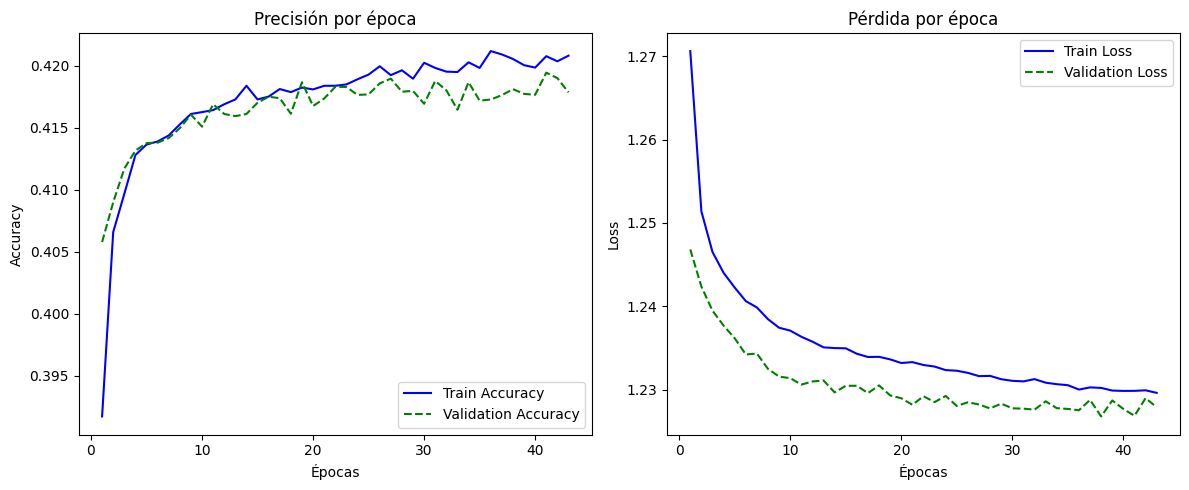

In [ ]:
plot_training_history(history)

####Tres capas intermedias

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3793 - loss: 1.2900 - val_accuracy: 0.4044 - val_loss: 1.2508
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4028 - loss: 1.2540 - val_accuracy: 0.4098 - val_loss: 1.2407
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4098 - loss: 1.2470 - val_accuracy: 0.4131 - val_loss: 1.2382
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4120 - loss: 1.2418 - val_accuracy: 0.4150 - val_loss: 1.2359
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4155 - loss: 1.2396 - val_accuracy: 0.4149 - val_loss: 1.2328
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.4157 - loss: 1.2382 - val_accuracy: 0.4156 - val_loss: 1.2321
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.4145 - loss: 1.2373 - val_accuracy: 0.4156 - val_loss: 1.2316
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4160 - loss: 1.2357 - 

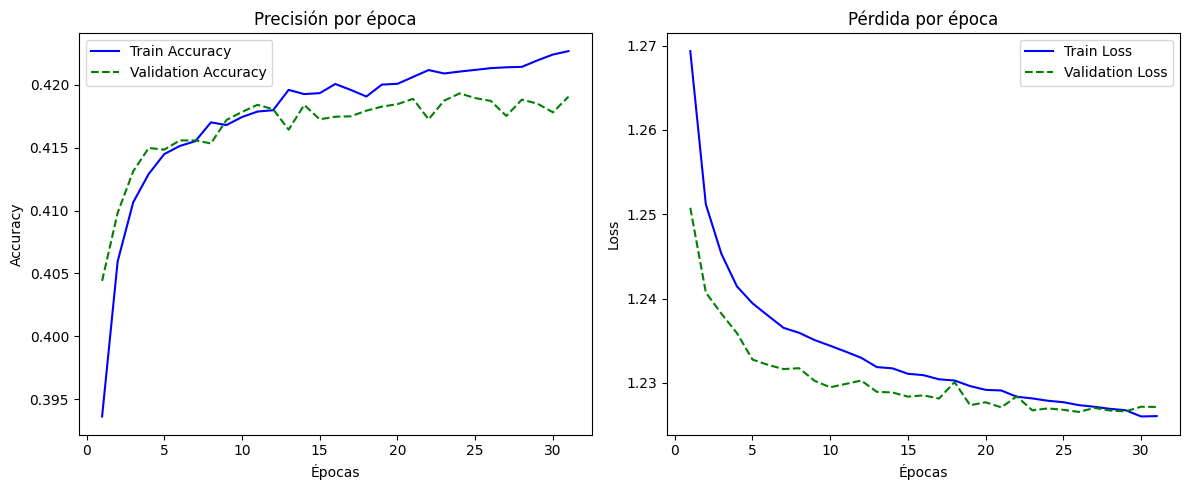

In [ ]:
plot_training_history(history)

###Escalando datos

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ordinal_cols = ['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'FAMI_ESTRATOVIVIENDA',
                'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA']

float_cols = ['coef_1', 'coef_2', 'coef_3', 'coef_4']

binary_cols = [col for col in X.columns if col not in ordinal_cols + float_cols]

preprocessor = ColumnTransformer([
    ('scale_ord', StandardScaler(), ordinal_cols + float_cols),
    ('passthrough_bin', 'passthrough', binary_cols)
])

X_scaled = preprocessor.fit_transform(X)

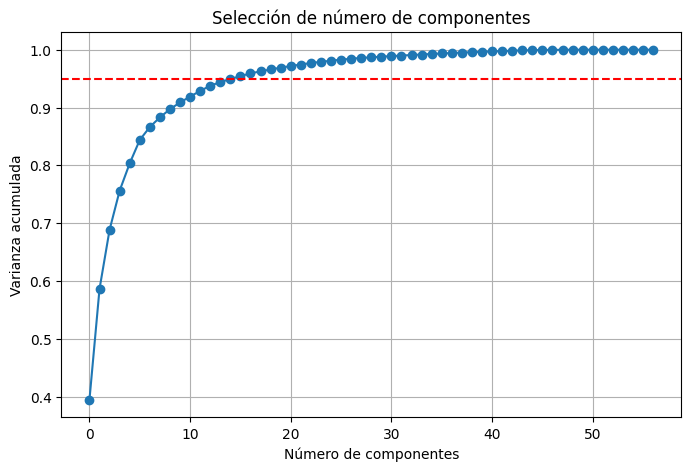

Se necesitan 16 componentes para conservar el 95% de la varianza


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled)

# Varianza acumulada
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(cumulative_var, marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.grid(True)
plt.axhline(0.95, color='r', linestyle='--')  # Umbral deseado
plt.title("Selección de número de componentes")
plt.show()

# Elegir el número que conserve al menos el 95%
n_components = np.argmax(cumulative_var >= 0.95) + 1
print(f"Se necesitan {n_components} componentes para conservar el 95% de la varianza")

In [ ]:
pca = PCA(n_components=45)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [ ]:
Xtr, Xts, ytr, yts = train_test_split(X_pca,y, test_size=0.3)
ytr = pd.get_dummies(ytr).astype(int)
yts = pd.get_dummies(yts).astype(int)

#####Sin capas intermedias

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Dense(4, activation='softmax'),
  ])

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(Xtr, ytr, epochs=20, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print()
print(f"Train accuracy {acc_tr}, Test accuracy: {acc}")

Epoch 1/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3227 - loss: 1.4234 - val_accuracy: 0.3792 - val_loss: 1.2880
Epoch 2/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3817 - loss: 1.2855 - val_accuracy: 0.3821 - val_loss: 1.2846
Epoch 3/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3828 - loss: 1.2839 - val_accuracy: 0.3819 - val_loss: 1.2842
Epoch 4/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3830 - loss: 1.2834 - val_accuracy: 0.3816 - val_loss: 1.2843
Epoch 5/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3825 - loss: 1.2838 - val_accuracy: 0.3820 - val_loss: 1.2843
Epoch 6/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3833 - loss: 1.2838 - val_accuracy: 0.3812 - val_loss: 1.2842
Epoch 7/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3837 - loss: 1.2840 - val_accuracy: 0.3815 - val_loss: 1.2843
Epoch 8/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3821 - loss: 1.2837 - val_accuracy: 0.

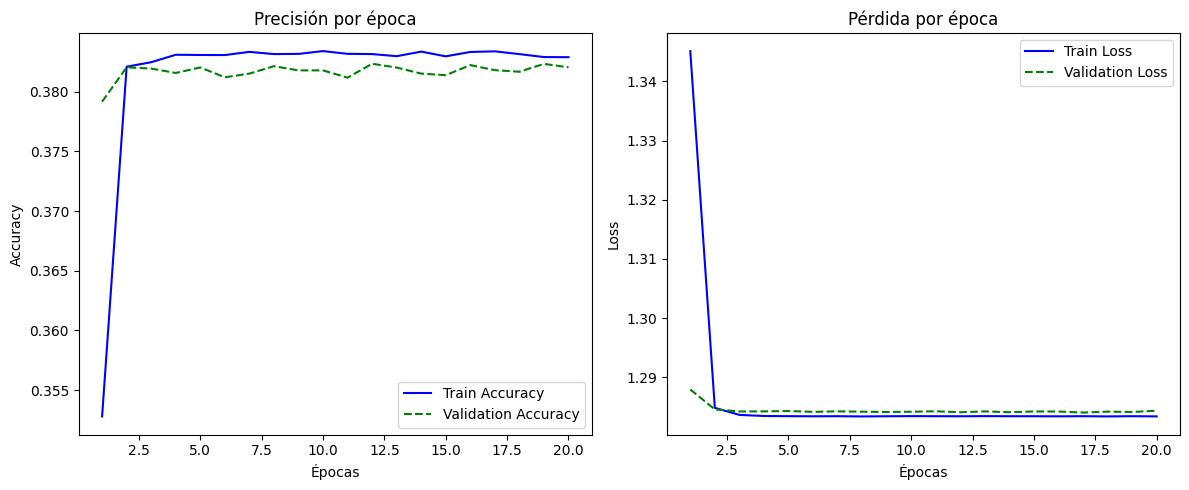

In [ ]:
plot_training_history(history)

####Una capa intermedia

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3713 - loss: 1.3012 - val_accuracy: 0.3829 - val_loss: 1.2834
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3858 - loss: 1.2790 - val_accuracy: 0.3928 - val_loss: 1.2677
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3995 - loss: 1.2593 - val_accuracy: 0.4035 - val_loss: 1.2535
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4043 - loss: 1.2520 - val_accuracy: 0.4073 - val_loss: 1.2488
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4061 - loss: 1.2496 - val_accuracy: 0.4069 - val_loss: 1.2470
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4083 - loss: 1.2458 - val_accuracy: 0.4097 - val_loss: 1.2446
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4102 - loss: 1.2436 - val_accuracy: 0.4114 - val_loss: 1.2420
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4119 - loss: 1.2417 - val_accuracy: 0.

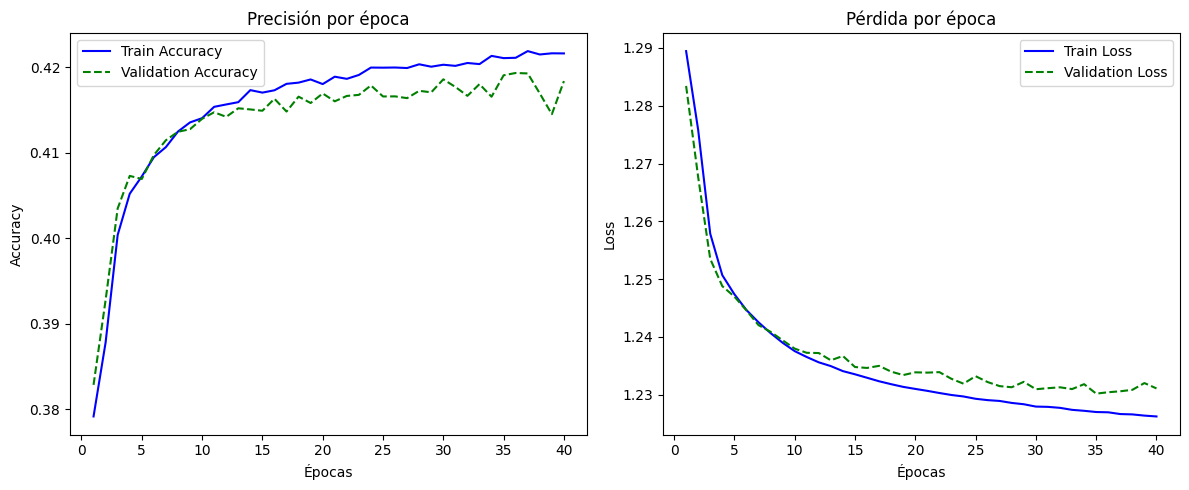

In [ ]:
plot_training_history(history)

####Dos capas intermedias

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])

_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3762 - loss: 1.2909 - val_accuracy: 0.4074 - val_loss: 1.2492
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4061 - loss: 1.2520 - val_accuracy: 0.4101 - val_loss: 1.2436
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4096 - loss: 1.2474 - val_accuracy: 0.4122 - val_loss: 1.2403
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4117 - loss: 1.2437 - val_accuracy: 0.4125 - val_loss: 1.2389
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4120 - loss: 1.2431 - val_accuracy: 0.4148 - val_loss: 1.2377
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4128 - loss: 1.2418 - val_accuracy: 0.4157 - val_loss: 1.2356
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4150 - loss: 1.2403 - val_accuracy: 0.4166 - val_loss: 1.2350
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4136 - loss: 1.2396 - val_accuracy: 0.

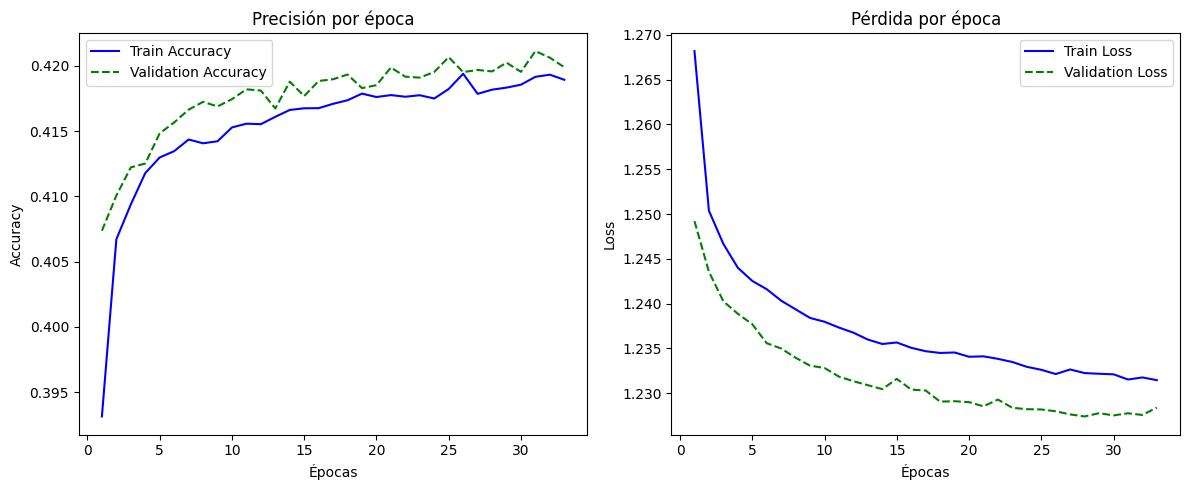

In [ ]:
plot_training_history(history)

####Tres capas intermedias

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3837 - loss: 1.2819 - val_accuracy: 0.4097 - val_loss: 1.2464
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4061 - loss: 1.2517 - val_accuracy: 0.4140 - val_loss: 1.2410
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4114 - loss: 1.2460 - val_accuracy: 0.4138 - val_loss: 1.2382
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4110 - loss: 1.2430 - val_accuracy: 0.4167 - val_loss: 1.2349
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4121 - loss: 1.2407 - val_accuracy: 0.4182 - val_loss: 1.2335
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.4141 - loss: 1.2397 - val_accuracy: 0.4175 - val_loss: 1.2319
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4161 - loss: 1.2364 - val_accuracy: 0.4180 - val_loss: 1.2317
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4169 - loss: 1.2359 - v

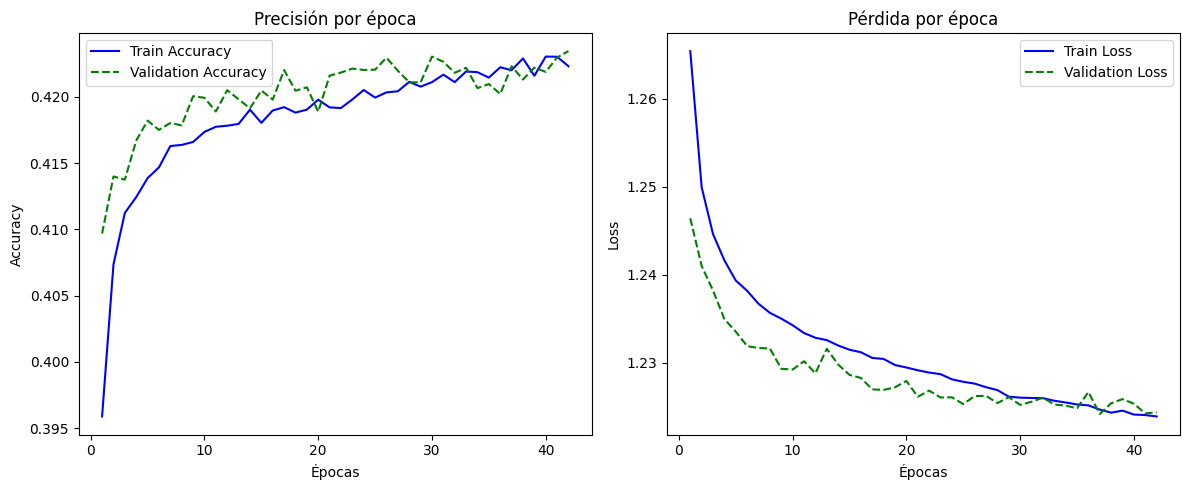

In [ ]:
plot_training_history(history)

Hacer una normalización de los datos no incrementa notablemente el resultado final del modelo sin embargo se considera una buena práctica y se mantiene este enfoque en análisis posteriores

####Evaluando 4 capas

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.3803 - loss: 1.2876 - val_accuracy: 0.4093 - val_loss: 1.2468
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.4053 - loss: 1.2548 - val_accuracy: 0.4106 - val_loss: 1.2437
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.4094 - loss: 1.2482 - val_accuracy: 0.4144 - val_loss: 1.2369
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.4123 - loss: 1.2439 - val_accuracy: 0.4164 - val_loss: 1.2360
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.4126 - loss: 1.2428 - val_accuracy: 0.4176 - val_loss: 1.2337
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.4124 - loss: 1.2421 - val_accuracy: 0.4186 - val_loss: 1.2337
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.4142 - loss: 1.2388 - val_accuracy: 0.4187 - val_loss: 1.2332
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.4163 - loss: 1.2383 - 

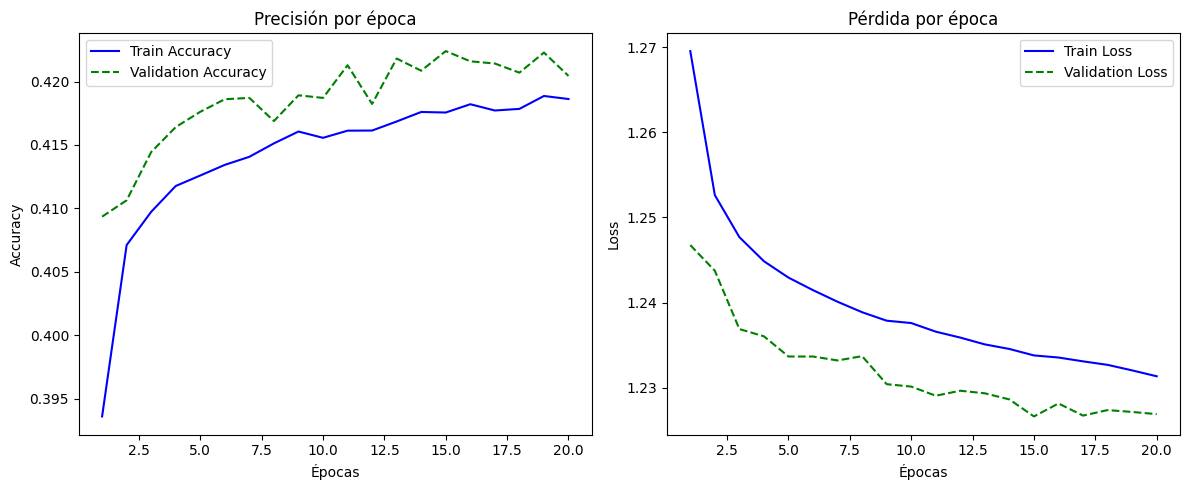

In [ ]:
plot_training_history(history)

Una evaluación final parece indicar que un modelo optimo no requiere del uso de más de 3 capas intermedias o con tantas neuronas como esta última propuesta. Por lo tanto se manejará un modelo de 3 capas

###Calibración con todo el conjunto de datos

In [ ]:
pca = PCA(n_components=45)
pca.fit(X)
X_pca = pca.transform(X)
y = pd.get_dummies(y).astype(int)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(X_pca, y, epochs=30, batch_size=512,verbose=1)

Epoch 1/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.3862 - loss: 1.2790
Epoch 2/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.4104 - loss: 1.2448
Epoch 3/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.4139 - loss: 1.2396
Epoch 4/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.4140 - loss: 1.2382
Epoch 5/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.4161 - loss: 1.2353
Epoch 6/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.4179 - loss: 1.2342
Epoch 7/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.4165 - loss: 1.2349
Epoch 8/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.4172 - loss: 1.2314
Epoch 9/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.4199 - loss: 1.2317
Epoch 10/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.4185 - loss: 1.2316
Epoch 11/30
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.4201 - loss: 1.2291
Epoch 12

##Predicción

In [ ]:
test_df = pd.read_csv("test.csv")
print(test_df.shape)
test_df_processed = process_data(test_df, programs_df)
print(test_df_processed.shape)
X_test = test_df_processed.drop(columns=['ESTU_PRGM_ACADEMICO'])
X_test_scaled = preprocessor.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

(296786, 20)


/tmp/ipython-input-4-3166745170.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


(296786, 58)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [ ]:
Y_pred = model.predict(X_test_pca)


9275/9275 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred.shape)
y_pred[:10]

(296786,)


array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0])

###Dataframe de predicción

In [ ]:
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
y_pred = pd.DataFrame(y_pred, columns=['RENDIMIENTO_GLOBAL'])
y_pred = y_pred.replace(dict(zip(range(4), grades)))
y_pred.head()
prediction_df = pd.concat([test_df['ID'], y_pred], axis=1).set_index('ID')
print(prediction_df.shape)
prediction_df.head()

(296786, 1)


,RENDIMIENTO_GLOBAL
ID,
550236,bajo
98545,bajo
499179,bajo
782980,bajo
785185,bajo


###Exportando el archivo

In [ ]:
prediction_df.to_csv("submission.csv")